### Prototypical Projection Based Anomaly Detector
###   Code by F. Vides, E. Segura, C. Vargas
###   For Paper, "On Operator Theory-Based Anomaly Detection in Cyber-Physical Systems"
###   by F. Vides, E. Segura, C. Vargas
### @authors: F. Vides, E. Segura, C. Vargas

## Import the relevant functions from libraries

In [1]:
from matplotlib.pyplot import plot,subplot,show,grid,tight_layout, figure, savefig
from numpy.linalg import svd
from numpy import zeros, real, append, ones, where, nan
from numpy.random import randn
from scipy.linalg import hankel
from pandas import read_excel,read_csv
from statistics import mean,stdev
import numpy as np
import time

## The function to detect the anomalies

In [2]:
def InversePowerMethod(A,tol, kIterMax,q0):
    
    import numpy as np
    
    n = A.shape[0]

    x = np.random.rand(n).reshape(-1,1)

    B = A.copy()

    error = 1
    
    #First Run
    for od in range(n):
            B[od,od] = A[od,od] - q0
        
    x = np.linalg.solve(B,x)
    x = x/np.linalg.norm(x)
    lamOld = x.T@A@x
    
    kIter = 1
    
    while kIter < kIterMax:
        
        #od = on diagonal
        for od in range(n):
            B[od,od] = A[od,od] - q0
        
        x = np.linalg.solve(B,x)
        x = x/np.linalg.norm(x)
        lamNew = x.T@A@x
        kIter = kIter + 1
        
        error = np.abs(lamNew - lamOld)
        if error < tol:
            return (x, lamNew, kIter)
        else:
            lamOld = lamNew
        
        
        
    return (x, lamNew, kIter)

In [3]:
def AnomalyDetectorSVD(signal, L, N_hankel, tolerance):
    from numpy.linalg import svd
    from numpy import zeros, where, nan, ones
    from statistics import mean,stdev
    from scipy.linalg import hankel
    
    x1 = signal.copy()
    xm = mean(signal)
    x0 = signal - xm


    H = hankel(x0[:L],x0[(L-1):N_hankel])
    u = svd(H,full_matrices=0)[0]
    p = u[:,-1]

    lp = len(p)
    lx = len(x0)
    N = lx-lp

    d0 = zeros(lx)
    d1 = zeros(lx)

    for k in range(N):
        d0[k+lp-1] = abs(p.T@x0[(k):(k+lp)])
        d1[N-k-1] = abs(p.T@x0[(lx-k-lp):(lx-k)])

    threshold0 = tolerance*stdev(d0)
    threshold1 = tolerance*stdev(d1)
   
    
    d0 = (d0 >= threshold0)
    d1 = (d1 >= threshold1)

    d = d0*d1

    di = where(d==1)
    y = nan*ones(lx)
    y[di] = x0[di]
    
    return(d,y,x0,x1,xm)

In [4]:
def AnomalyDetectorIPM(signal, L, N_hankel, tolerance, tolIPM, kIterMax, q0):
    from numpy import zeros, where, nan, ones
    from statistics import mean,stdev
    from scipy.linalg import hankel
    
    x1 = signal.copy()
    xm = mean(signal)
    x0 = signal - xm


    H = hankel(x0[:L],x0[(L-1):N_hankel])
    H1 = H@H.T
    p, lam, kIter = InversePowerMethod(A=H1, tol=tolIPM, 
                                       kIterMax = kIterMax, q0 = q0)

    lp = len(p)
    lx = len(x0)
    N = lx-lp

    d0 = zeros(lx)
    d1 = zeros(lx)

    for k in range(N):
        d0[k+lp-1] = abs(p.T@x0[(k):(k+lp)])
        d1[N-k-1] = abs(p.T@x0[(lx-k-lp):(lx-k)])

    threshold0 = tolerance*stdev(d0)
    threshold1 = tolerance*stdev(d1)
   
    
    d0 = (d0 >= threshold0)
    d1 = (d1 >= threshold1)

    d = d0*d1

    di = where(d==1)
    y = nan*ones(lx)
    y[di] = x0[di]
    
    return(d,y,x0,x1,xm)

## The function to plot the anomalies region

In [5]:
def plotAnomalyDetector(signal, rest, figsize):
    
    from matplotlib.pyplot import plot,subplot,grid,tight_layout
    from matplotlib.pyplot import figure, savefig
    
    (d,y,x0,x1,xm) = rest
    
    figure(figsize =figsize)
    ax1 = subplot(3,1,1)
    plot(signal,'blue')
    grid(color='k', linestyle='--', linewidth=0.5)
    ax1.set_title('Signal', fontsize=12)
    
    ax2 = subplot(3,1,2)
    plot(d,'darkorange')
    grid(color='k', linestyle='--', linewidth=0.5)
    ax2.set_title('Identified scanning region', fontsize=12)
    tight_layout()
    ax3 = subplot(3,1,3)
    
    plot(signal,'blue')
    #plot(y+xm,'darkorange')
    plot(d*x0+xm,'darkorange')
    grid(color='k', linestyle='--', linewidth=0.5)
    ax3.set_title('Identified anomalies', fontsize=12)
    tight_layout()
    #savefig(save_signal_figure)
    show()

# The anomaly detector working

### Let's set the figure size here

In [35]:
figsize = (13,7)

### First, read the file that has the first signal

In [36]:
signal = read_csv('../Data/real_signal_1.csv', header = None)
signal = signal.values.reshape(-1)

### Now we get the regions that have the anomilies
### We set values for L, N_hankel and sensitity (after the calibration made before done with the anomaly_detector_calibration_widget notebook) 

In [20]:
L = 75
N_hankel = 1300
tolerance = 0.4

### Now we apply the Anomaly Detector function to get the time where there is an anomaly given the L, N_hankel and tolerance

### First with the SVD Method

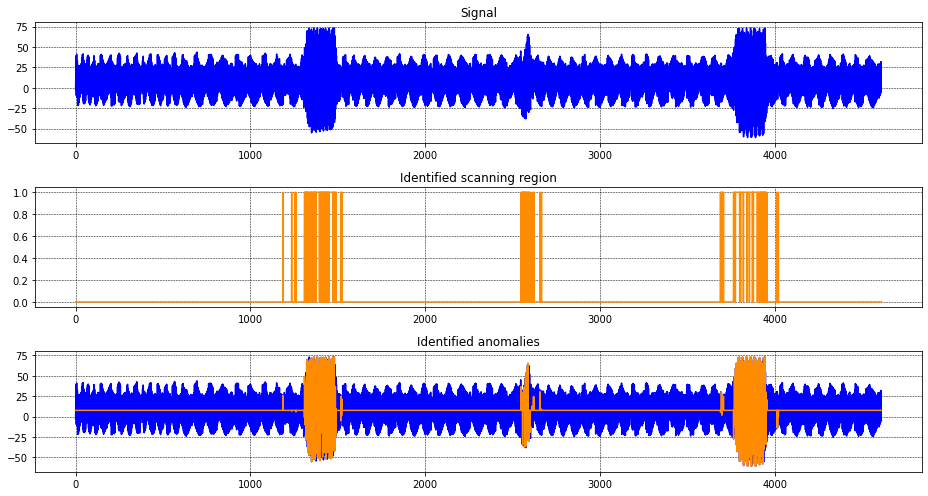

In [21]:
rest = AnomalyDetectorSVD(signal = signal, L = L,
                          N_hankel = N_hankel,
                          tolerance = tolerance )
plotAnomalyDetector(signal, rest, figsize = figsize)

### Second with the Inverse Power Method

### Define some parameters for the convergence of the Inverse Power Method

In [9]:
tolIPM = 1e-8
kIterMax = 200
#This q0 is an approximation to the lowest singular value
#This can be estimated by other methods, but here we use it as known
q0 = 48.093 + 1e-3 

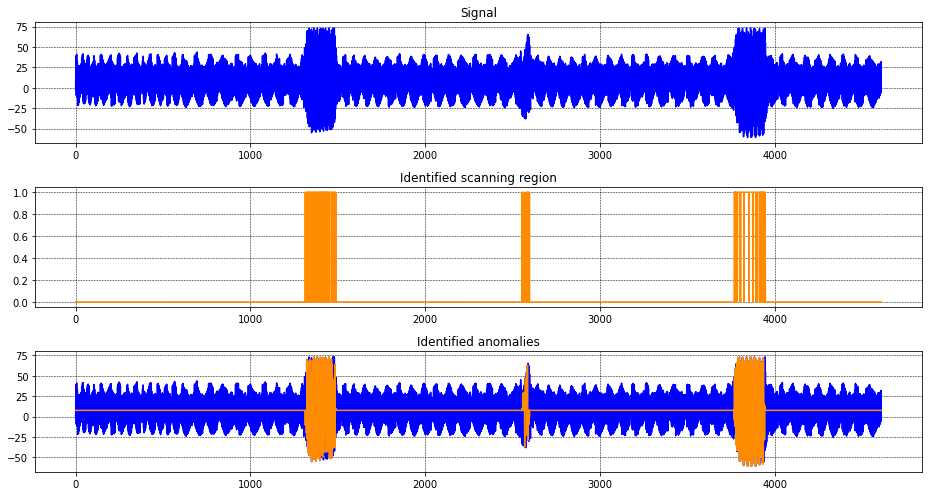

In [12]:
rest = AnomalyDetectorIPM(signal = signal, L = L, N_hankel = N_hankel,
                        tolerance = tolerance, tolIPM = tolIPM, 
                        kIterMax = kIterMax, q0 = q0)
plotAnomalyDetector(signal, rest, figsize = figsize)

## Let's do it for the second signal

In [14]:
signal = read_csv('../Data/real_signal_2.csv', header = None)
signal = signal.values.reshape(-1)

### Now we get the regions that have the anomilies
### We set values for L, N_hankel and sensitity (after the calibration made before done with the anomaly_detector_calibration_widget notebook) 

In [15]:
L = 60
N_hankel = 900
tolerance = 0.74

### With the SVD Method

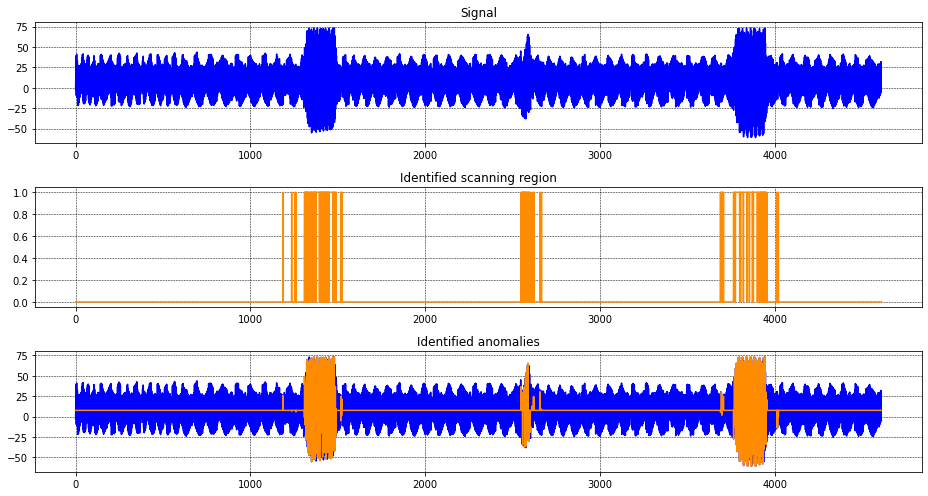

In [22]:
rest = AnomalyDetectorSVD(signal = signal, L = L,
                          N_hankel = N_hankel,
                          tolerance = tolerance )
plotAnomalyDetector(signal, rest, figsize = figsize)

### With the Inverse Power Method

In [25]:
tolIPM = 1e-8
kIterMax = 200
#This q0 is an approximation to the lowest singular value
#This can be estimated by other methods, but here we use it as known
q0 = 48.093 + 1e-3 

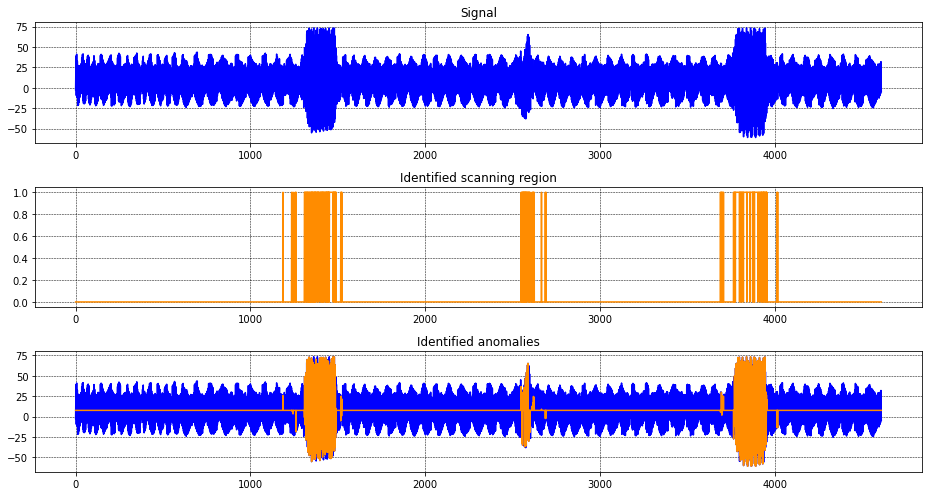

In [27]:
rest = AnomalyDetectorIPM(signal = signal, L = L, N_hankel = N_hankel,
                        tolerance = tolerance, tolIPM = tolIPM, 
                        kIterMax = kIterMax, q0 = q0)
plotAnomalyDetector(signal, rest, figsize = figsize)

## Let's the the effect of chosing a different tolerance for the anomaly detection

### Let'se use signal 1

In [29]:
signal = read_csv('../Data/real_signal_1.csv', header = None)
signal = signal.values.reshape(-1)

In [30]:
L = 75
N_hankel = 1300

### Here we define the different tolerances to compare

In [31]:
tolerance_1 = 2.4
tolerance_2 = 0.4
tolerance_3 = 0.1

### Detect with the three different tolerances
### Using the SVD Method

In [38]:
rest_1 = AnomalyDetectorSVD(signal = signal, L = L, N_hankel = N_hankel,
                        tolerance = tolerance_1 )
rest_2 = AnomalyDetectorSVD(signal = signal, L = L, N_hankel = N_hankel,
                        tolerance = tolerance_2 )
rest_3 = AnomalyDetectorSVD(signal = signal, L = L, N_hankel = N_hankel,
                        tolerance = tolerance_3 )

(d1,y,x0,x1,xm) = rest_1
(d2,y,x0,x1,xm) = rest_2
(d3,y,x0,x1,xm) = rest_3

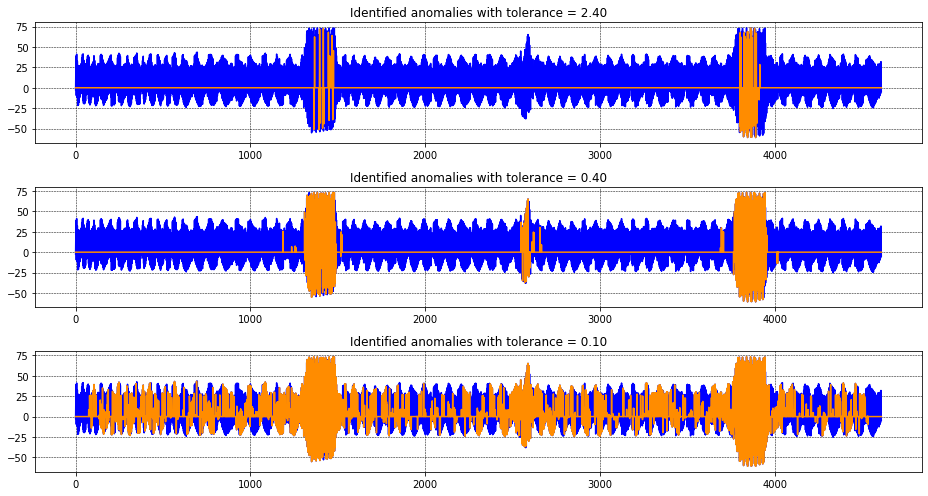

In [39]:
figure(figsize =figsize)

ax1 = subplot(3,1,1)
plot(signal,'blue')
plot(d1*signal,'darkorange')
grid(color='k', linestyle='--', linewidth=0.5)
ax1.set_title('Identified anomalies with tolerance = {:2.2f}'.format(tolerance_1),
              fontsize=12)
tight_layout()



ax2 = subplot(3,1,2)
plot(signal,'blue')
plot(d2*signal,'darkorange')
grid(color='k', linestyle='--', linewidth=0.5)
ax2.set_title('Identified anomalies with tolerance = {:2.2f}'.format(tolerance_2), 
              fontsize=12)
tight_layout()


ax3 = subplot(3,1,3)
plot(signal,'blue')
plot(d3*signal,'darkorange')
grid(color='k', linestyle='--', linewidth=0.5)
ax3.set_title('Identified anomalies with tolerance = {:2.2f}'.format(tolerance_3), fontsize=12)
tight_layout()